## Real State Dashboard

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("All packages imported successfully!")

All packages imported successfully!


In [2]:
# Load your dataset
df = pd.read_csv('/Users/ayushchhoker/Desktop/Study/Data Science Work/Projects/Projects/Projects/Real_state_dashboard/Real_Estate.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (414, 7)

First 5 rows:
             Transaction date  House age  Distance to the nearest MRT station  \
0  2012-09-02 16:42:30.519336       13.3                            4082.0150   
1  2012-09-04 22:52:29.919544       35.5                             274.0144   
2  2012-09-05 01:10:52.349449        1.1                            1978.6710   
3  2012-09-05 13:26:01.189083       22.2                            1055.0670   
4  2012-09-06 08:29:47.910523        8.5                             967.4000   

   Number of convenience stores   Latitude   Longitude  \
0                             8  25.007059  121.561694   
1                             2  25.012148  121.546990   
2                            10  25.003850  121.528336   
3                             5  24.962887  121.482178   
4                             6  25.011037  121.479946   

   House price of unit area  
0                  6.488673  
1                 24.970725  
2                 26.694267  
3    

### Data Cleaning and Preparation

Missing values per column:
Series([], dtype: int64)


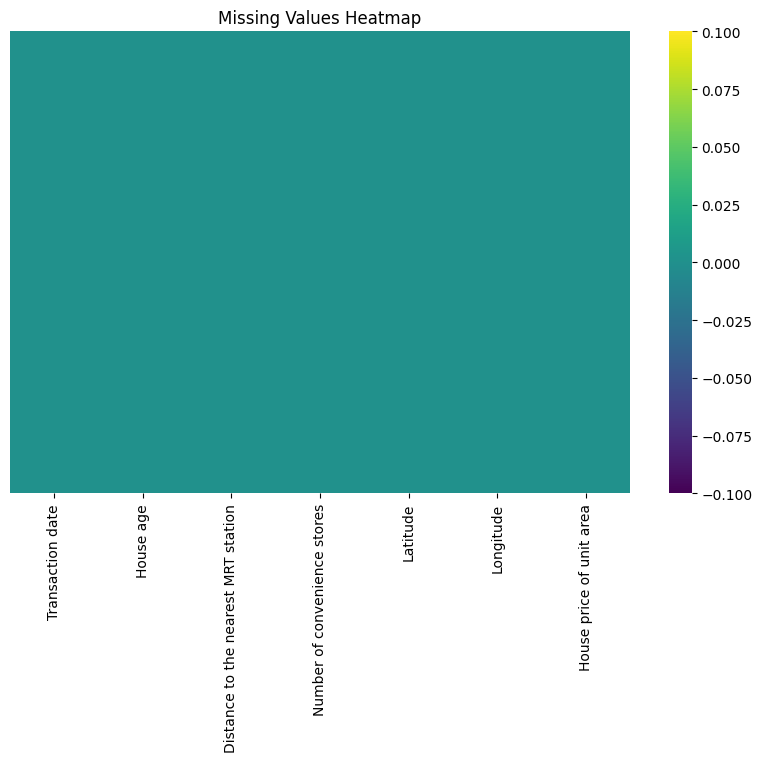

In [3]:
# Check missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [6]:
# Strategy 1: Drop rows with missing values (if few)
df_cleaned = df.dropna()

# Strategy 2: Fill missing values
# For numerical columns - use median
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    
    df[col].fillna(df[col].median(), inplace=True)

# For categorical columns - use mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [7]:
# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply to price column (using correct column name)
df_clean = remove_outliers(df, 'House price of unit area')
print(f"Removed {len(df) - len(df_clean)} outliers")

Removed 0 outliers


In [8]:
# Convert categorical variables to numerical
# Since this dataset doesn't have zipcode, we'll work with what we have
# The Transaction date can be processed for temporal features

# Convert Transaction date to datetime
df['Transaction date'] = pd.to_datetime(df['Transaction date'])

# Extract temporal features
df['year'] = df['Transaction date'].dt.year
df['month'] = df['Transaction date'].dt.month
df['day'] = df['Transaction date'].dt.day

print("Temporal features extracted from Transaction date")

Temporal features extracted from Transaction date


### Feature Engineerin

In [9]:
# Feature Engineering for this dataset
# Distance category (binning distance to MRT)
df['distance_category'] = pd.cut(df['Distance to the nearest MRT station'], 
                                bins=[0, 500, 1000, 2000, float('inf')], 
                                labels=['Very Close', 'Close', 'Moderate', 'Far'])

# Convenience score (normalized)
df['convenience_score'] = df['Number of convenience stores'] / df['Number of convenience stores'].max()

# Location features (latitude/longitude zones)
df['lat_zone'] = pd.cut(df['Latitude'], bins=5, labels=['South', 'South-Mid', 'Central', 'North-Mid', 'North'])
df['long_zone'] = pd.cut(df['Longitude'], bins=5, labels=['West', 'West-Mid', 'Central', 'East-Mid', 'East'])

print("Feature engineering completed for this dataset")

Feature engineering completed for this dataset


In [10]:
# Prepare features for modeling
# Select numerical features for the model
numerical_features = ['House age', 'Distance to the nearest MRT station', 
                     'Number of convenience stores', 'Latitude', 'Longitude', 
                     'year', 'month', 'day', 'convenience_score']

# Get categorical features encoded
categorical_features = pd.get_dummies(df[['distance_category', 'lat_zone', 'long_zone']])

# Combine features
X = pd.concat([df[numerical_features], categorical_features], axis=1)
y = df['House price of unit area']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Target variable shape: {y.shape}")

Feature matrix shape: (414, 23)
Target variable shape: (414,)


### Exploratory Data Analysis (EDA)

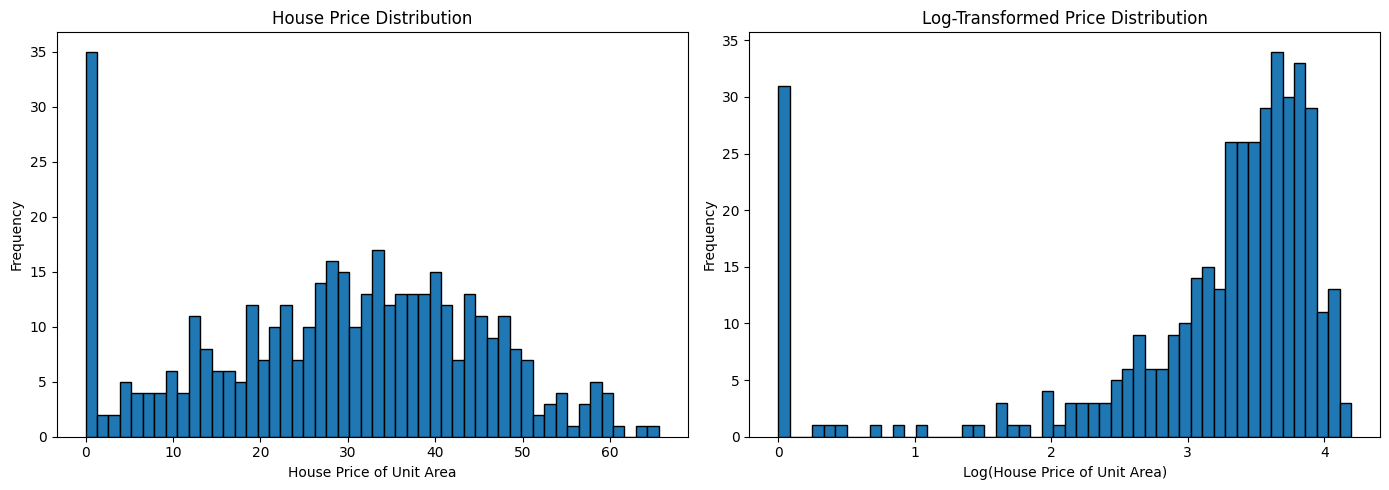

In [17]:
# Price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['House price of unit area'], bins=50, edgecolor='black')
axes[0].set_title('House Price Distribution')
axes[0].set_xlabel('House Price of Unit Area')
axes[0].set_ylabel('Frequency')

axes[1].hist(np.log1p(df['House price of unit area']), bins=50, edgecolor='black')
axes[1].set_title('Log-Transformed Price Distribution')
axes[1].set_xlabel('Log(House Price of Unit Area)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

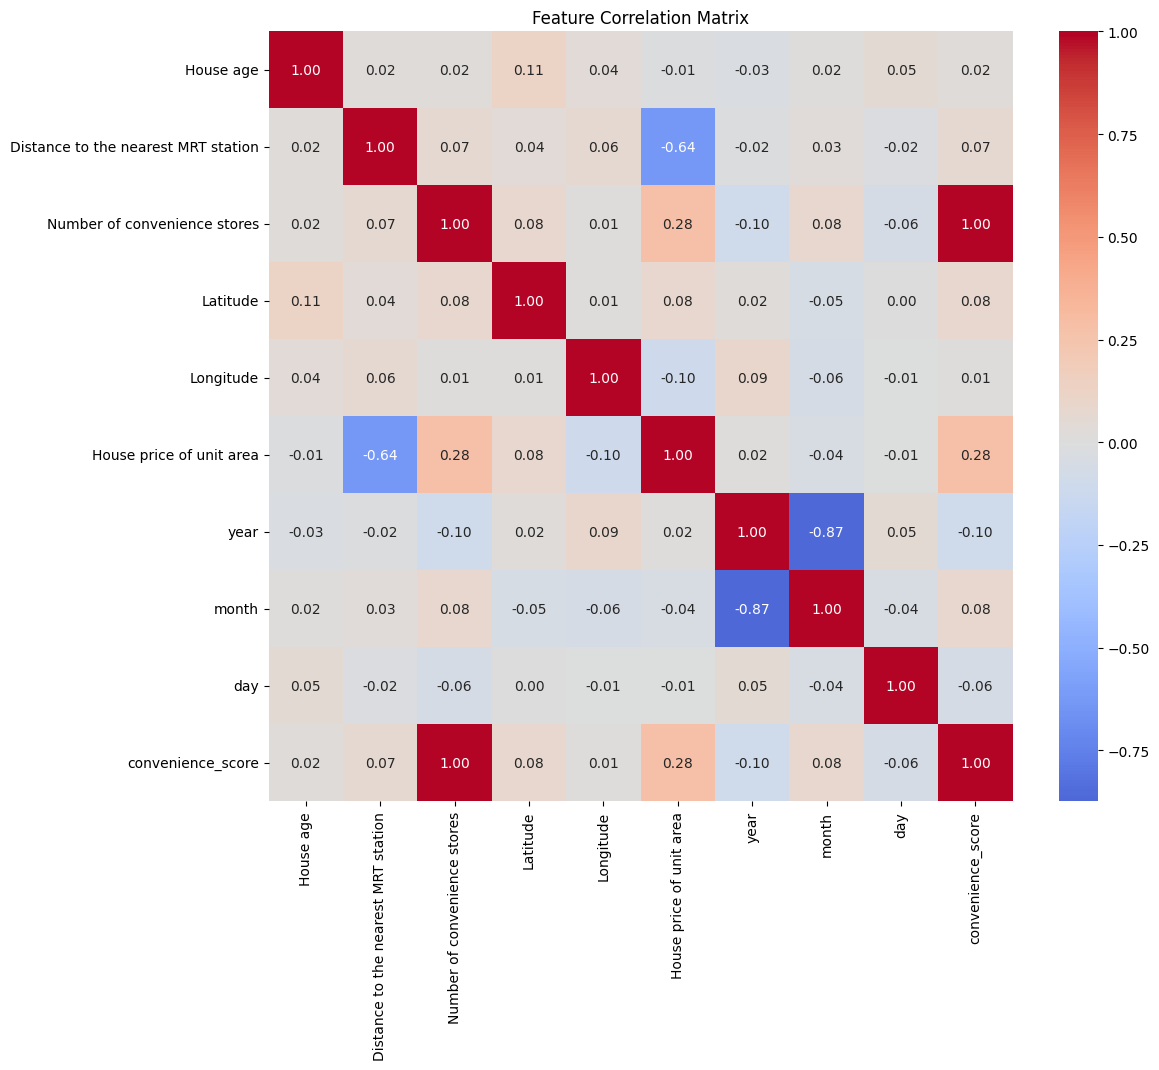

Top features correlated with house price:
House price of unit area               1.000000
convenience_score                      0.280763
Number of convenience stores           0.280763
Latitude                               0.081008
year                                   0.015745
day                                   -0.008659
House age                             -0.012284
month                                 -0.041256
Longitude                             -0.098626
Distance to the nearest MRT station   -0.636579
Name: House price of unit area, dtype: float64


In [11]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# Top correlated features with price
price_corr = correlation_matrix['House price of unit area'].sort_values(ascending=False)
print("Top features correlated with house price:")
print(price_corr)

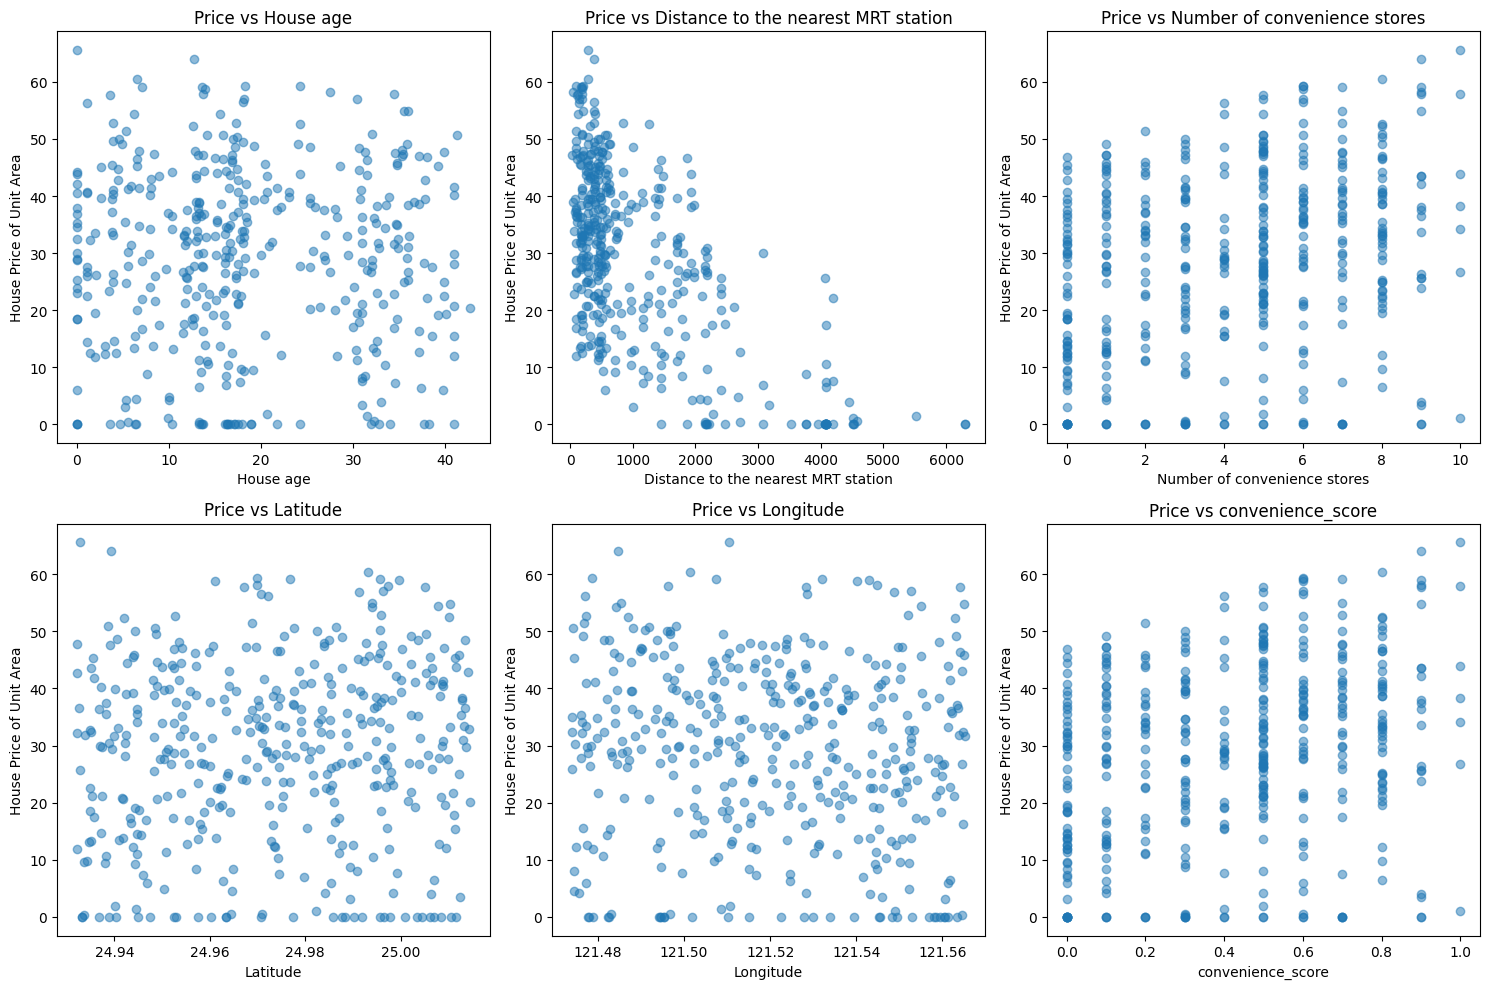

In [12]:
# Scatter plots for key features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
key_features = ['House age', 'Distance to the nearest MRT station', 'Number of convenience stores', 
                'Latitude', 'Longitude', 'convenience_score']

for idx, feature in enumerate(key_features):
    row = idx // 3
    col = idx % 3
    axes[row, col].scatter(df[feature], df['House price of unit area'], alpha=0.5)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('House Price of Unit Area')
    axes[row, col].set_title(f'Price vs {feature}')

plt.tight_layout()
plt.show()

### Model Selection and Training

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (331, 23)
Test set size: (83, 23)


In [14]:
# Dictionary to store models and results
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results[name] = {
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R2': train_r2,
        'Test R2': test_r2
    }
    
    print(f"\n{name}:")
    print(f"  Train RMSE: ${train_rmse:,.2f}")
    print(f"  Test RMSE: ${test_rmse:,.2f}")
    print(f"  Train R2: {train_r2:.4f}")
    print(f"  Test R2: {test_r2:.4f}")


Linear Regression:
  Train RMSE: $10.54
  Test RMSE: $11.29
  Train R2: 0.5362
  Test R2: 0.5394

Ridge Regression:
  Train RMSE: $10.54
  Test RMSE: $11.28
  Train R2: 0.5362
  Test R2: 0.5400

Lasso Regression:
  Train RMSE: $10.93
  Test RMSE: $11.19
  Train R2: 0.5015
  Test R2: 0.5471

Random Forest:
  Train RMSE: $4.45
  Test RMSE: $11.51
  Train R2: 0.9175
  Test R2: 0.5209

Gradient Boosting:
  Train RMSE: $6.69
  Test RMSE: $11.85
  Train R2: 0.8130
  Test R2: 0.4925


In [15]:
# Perform cross-validation for best model
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, 
                            scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print("Cross-Validation RMSE Scores:", cv_rmse)
print(f"Mean CV RMSE: ${cv_rmse.mean():,.2f}")
print(f"Std CV RMSE: ${cv_rmse.std():,.2f}")

Cross-Validation RMSE Scores: [12.09792912 12.57264833 11.2660344  12.89320328 10.48344747]
Mean CV RMSE: $11.86
Std CV RMSE: $0.88


### Hyperparameter Tuning

In [16]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, 
                          scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best CV Score: {np.sqrt(-grid_search.best_score_):,.2f}")

# Train final model with best parameters
best_rf_model = grid_search.best_estimator_

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best CV Score: 11.63


### Model Evaluation

In [18]:
# Make predictions with best model
y_pred = best_rf_model.predict(X_test)

# Calculate comprehensive metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Final Model Performance:")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

Final Model Performance:
RMSE: $11.44
MAE: $9.73
R² Score: 0.5266
MAPE: inf%


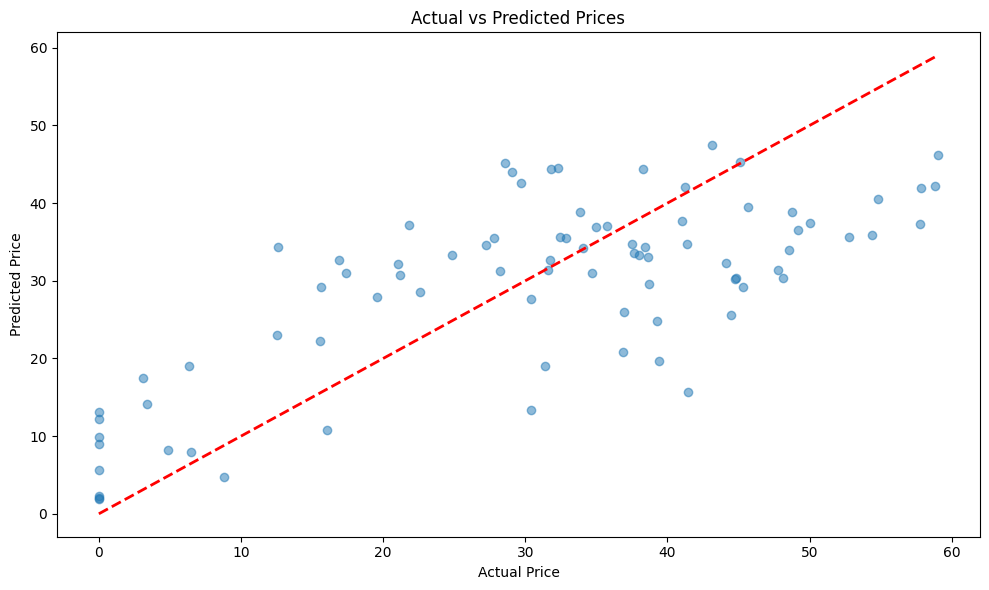

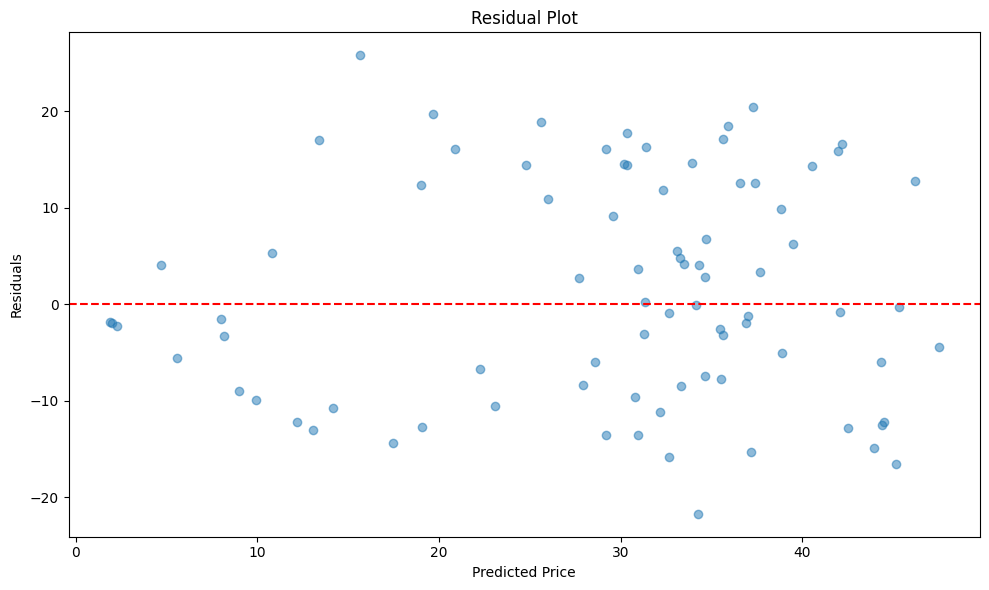

In [19]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

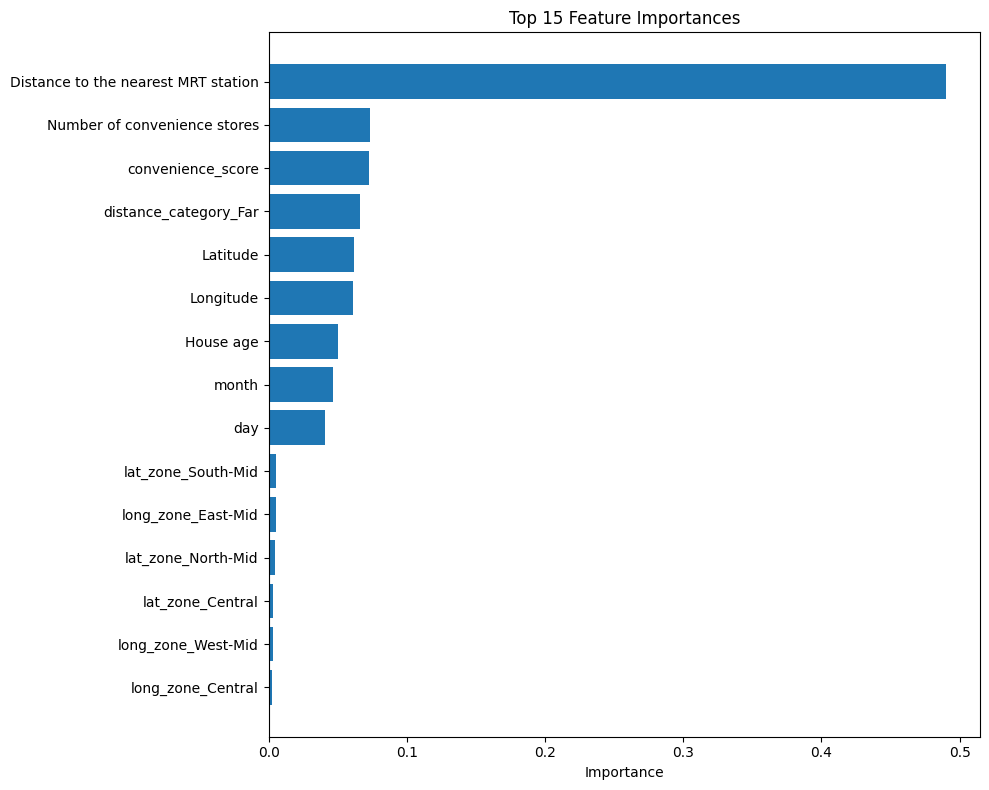

Top 10 Most Important Features:
                                feature  importance
1   Distance to the nearest MRT station    0.490262
2          Number of convenience stores    0.073482
8                     convenience_score    0.072907
12                distance_category_Far    0.066432
3                              Latitude    0.062120
4                             Longitude    0.060891
0                             House age    0.050183
6                                 month    0.046361
7                                   day    0.040881
14                   lat_zone_South-Mid    0.005516


In [20]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))